# Prediction of Product Sales

##### Jalicia Harris

### Imports

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Filter ALL warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## Setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Set pandas to display more columns
pd.set_option('display.max_columns', 20)

## Load and Inspect Data

In [3]:
# Load file, display column info, and preview rows
df = pd.read_csv('Data/sales_predictions_2023.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Clean Data

### 1. How many rows and columns?


In [4]:
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')

There are 8523 rows, and 12 columns.


### 2. What are the datatypes of each variables?

In [5]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Checking for Duplicates and Missing Values

In [6]:
# Check and delete any duplicates
sale = df.duplicated().sum()
print(f'There are {sale} duplicates')

There are 0 duplicates


In [7]:
# Identify missing values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## Identifying and Making Corrections


- The missing values in column 'Item_Weight' will be replaced with calculated mean.
- This missing values in the 'Outlet_Size' column will be replaced with value "Unknown"
- All other datatypes will remain as is.

In [8]:
# Replace missing values in 'Item Weight' column with the median
missing_data = df['Item_Weight'].mean()
df['Item_Weight'].fillna(missing_data, inplace = True)

In [9]:
# Replace missing values in 'Outlet_Size' column with value 'Unknown'
df['Outlet_Size'].fillna('N/A', inplace=True)
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Identify and Correct Any Inconsistencies

In [10]:
# Find any inconsistent categories of data
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [11]:
# Standarize the values in the 'Item_Fat_Content' column
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
# Confirm results
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## For any numerical columns, obtain the summary statistics of each (min, max, mean)

In [12]:
df.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.23,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,9.31,0.03,93.83,1987.00,834.25
50%,12.86,0.05,143.01,1999.00,1794.33
75%,16.00,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


## Exploratory Data Analysis

### Examining Distributions of Various Sections Using Histograms

---



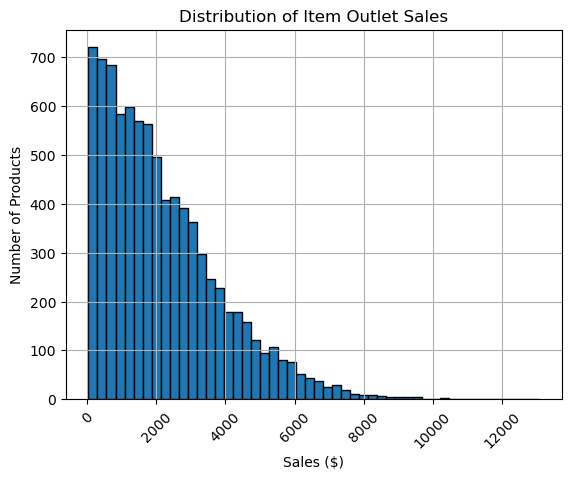

In [13]:
# Create a histogram to view the distributions of various features in the dateset
ax = df['Item_Outlet_Sales'].hist(bins=50, edgecolor = 'black')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Distribution of Item Outlet Sales')
ax.set_xlabel('Sales ($)')
ax.set_ylabel('Number of Products');

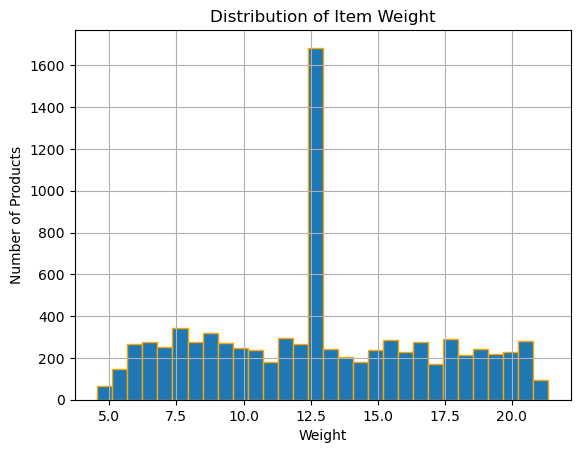

In [14]:
ax = df['Item_Weight'].hist(bins=30, edgecolor = 'orange')
ax.set_title('Distribution of Item Weight')
ax.set_xlabel('Weight')
ax.set_ylabel('Number of Products');

### Examine Statistical Summaries Using Boxplots

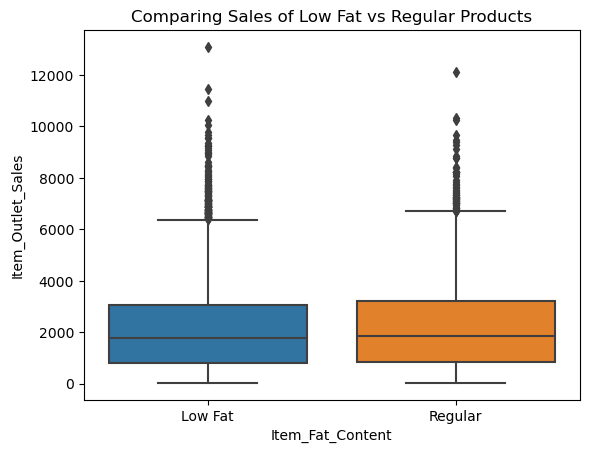

In [15]:
# Create a Boxplot to view statistical summaries of various features in the dataset
ax = sns.boxplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=df)
ax.set_title("Comparing Sales of Low Fat vs Regular Products");

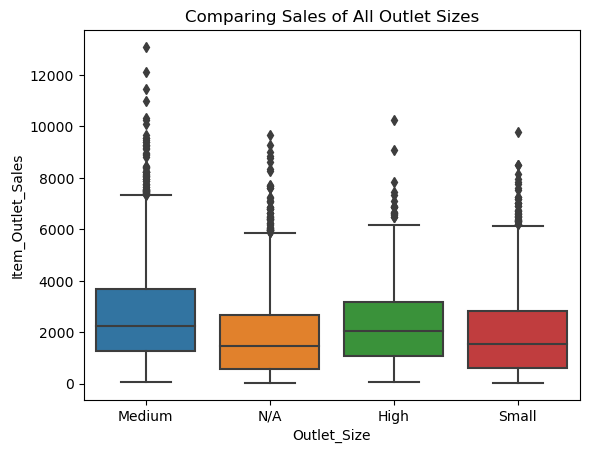

In [16]:
ax = sns.boxplot(x='Outlet_Size', y='Item_Outlet_Sales', data=df)
ax.set_title("Comparing Sales of All Outlet Sizes");

### Examine the Correlation Between Various Sections Using Heatmaps

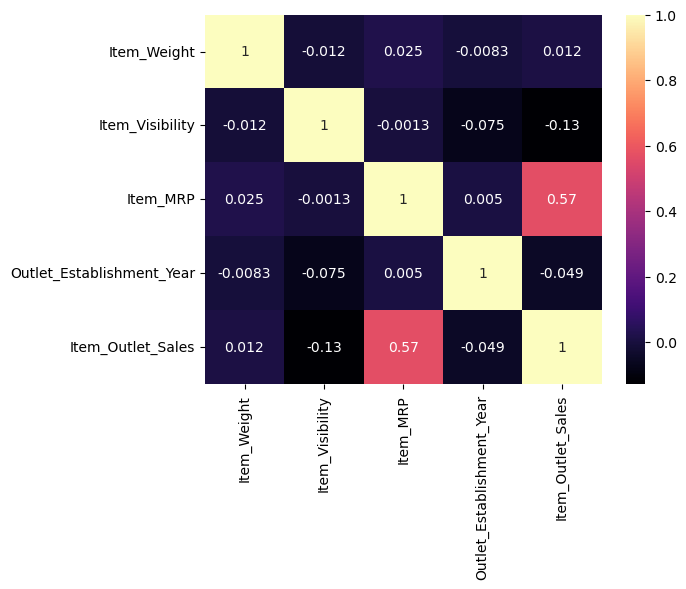

In [17]:
corr = df.corr()
sns.heatmap(corr, cmap = 'magma', annot=True);

## Explanatory Data Analysis

### Possible Questions to Answer:
##### 1. What outlet types have the highest sales?
##### 2. Which product types bring in the most profits?

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### 1. What outlet types have the highest sales?

In [19]:
# Get the average for each outlet type
type_mean = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean()
type_mean

Outlet_Type
Grocery Store         339.828500
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

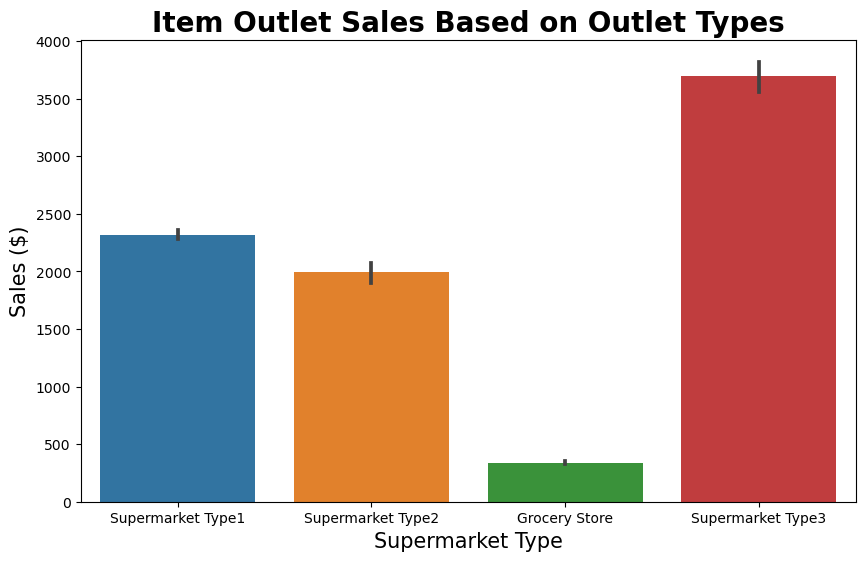

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(data=df, x='Outlet_Type', y='Item_Outlet_Sales')
ax.set_title('Item Outlet Sales Based on Outlet Types', fontsize=20, fontweight='bold');
ax.set_xlabel('Supermarket Type', fontsize=15)
ax.set_ylabel('Sales ($)', fontsize=15);

- The bar graph above shows that Supermarket Type 3 has the highest amount of sales.

### What product types bring in the most profits?

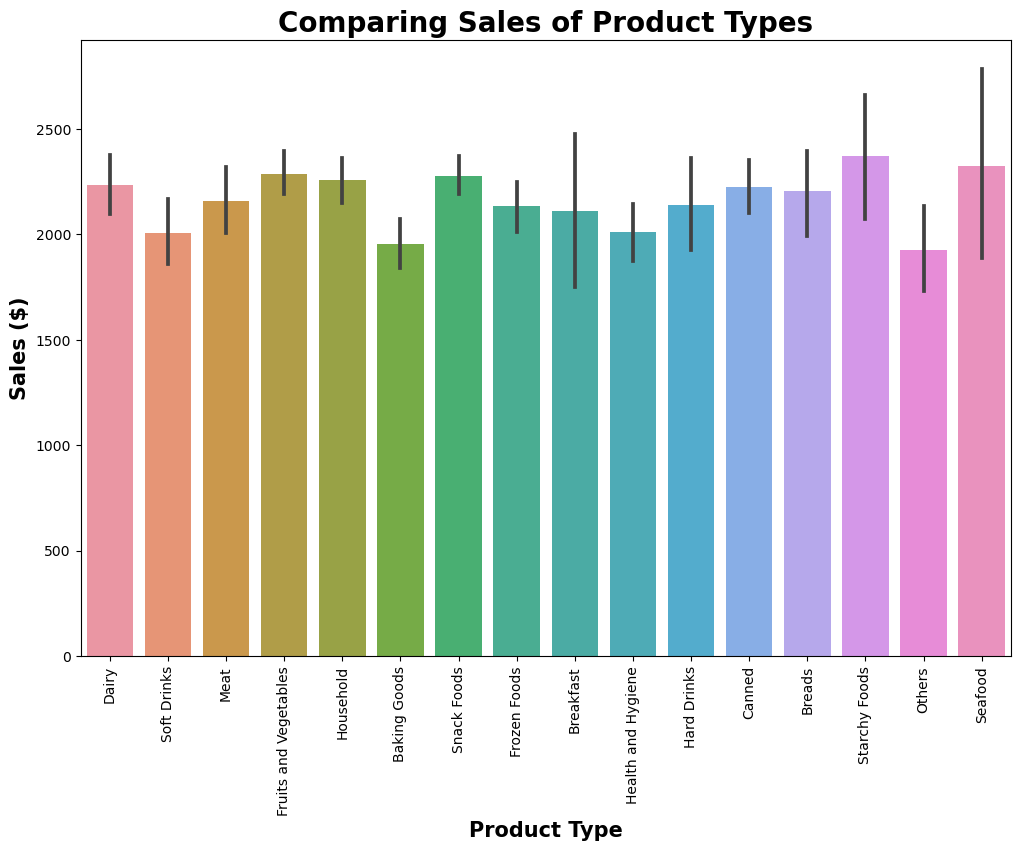

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(data=df, x='Item_Type', y='Item_Outlet_Sales')
ax.tick_params(axis='x', rotation=90)
ax.set_title("Comparing Sales of Product Types", fontsize=20, fontweight='bold');
ax.set_xlabel('Product Type', fontsize=15, fontweight='bold')
ax.set_ylabel('Sales ($)', fontsize=15, fontweight='bold');

- The bar graph above shows that starchy foods has the highest profits.

# (Core) Project 1 Revisited: Importances and Coefficients

## Task
- For this assignment, you will revisit your first project to predict supermarket sales. You will apply what you've learned this week to explain how your models made their predictions.

## Project 1 Revisited - Part 1: Remaking, Saving, and Explaining Your Models
For this part of the project, you will be producing a new version of your final project notebook using the updated tools in sklearn v1.2. You should continue to save your work in the same repo as your original Project 1. 

- Create a new notebook called "Project 1 - Revisited.ipynb" in your original project repo.
 - You may either make a copy of your prior notebook that you will modify,
or you can start a new blank notebook and copy over the code from your old notebook (as needed).
- Remake your X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.

In [22]:
# Reload original dataframe
df2 = pd.read_csv('Data/sales_predictions_2023.csv')
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [23]:
# Confirm new dataframe is the original version
df2.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### Train_Test_Split

In [24]:
# Make X and y variables
y = df2['Item_Outlet_Sales'].copy()
X = df2.drop(columns=['Item_Outlet_Sales', 'Item_Identifier']).copy()
# Train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,NaN,Tier 3,Grocery Store
7604,6.135,LF,0.079294,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1
6464,5.945,LF,0.093009,Household,127.8652,OUT035,2004,Small,Tier 2,Supermarket Type1
4707,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,OUT035,2004,Small,Tier 2,Supermarket Type1


### Preprocessing 


In [25]:
# Make categorical selector and verify it works
cat_select = make_column_selector(dtype_include='object')
cat_select(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [26]:
# Make numeric selector and verify it works
num_select = make_column_selector(dtype_include='number')
num_select(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [27]:
# Make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='N/A'),
                        OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

### Columntransformer

In [28]:
# Make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_select),
                                       (cat_pipe, cat_select),
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002335739DA30>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='N/A',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002335739DBE0>)],
                  verbose_feature_names_out=False)

### Extract Feature Names from Columntransfomer

In [29]:
# Fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Si

### Remake your X_train and X_test as DataFrames with the Feature Names

In [30]:
# Convert training data into dataframe
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns = feature_names, index = X_train.index)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Size_Medium,Outlet_Size_N/A,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.220,0.064142,61.2510,1998.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7604,6.135,0.079294,111.2860,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2762,12.150,0.028593,151.0708,2004.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6464,5.945,0.093009,127.8652,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4707,18.200,0.066285,247.2092,2004.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [31]:
# Convert test data into dataframe
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns = feature_names, index = X_test.index)
X_test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Size_Medium,Outlet_Size_N/A,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.250000,0.061531,132.2968,2007.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2391,17.850000,0.044463,127.1020,1997.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
163,7.270000,0.071078,114.2518,1997.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4608,12.822634,0.075142,145.8444,1985.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5544,13.500000,0.121633,161.6920,1998.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [32]:
# Confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

8077    1696.4584
2391    2024.0320
163     2618.5914
Name: Item_Outlet_Sales, dtype: float64

## LinearRegression
- Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.
- Extract and visualize the coefficients that your model determined.
 - Select the top 3 most impactful features and interpret their coefficients in plain English.
- Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).

In [33]:
# Create custom function for regression evaluation
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")


In [34]:
# Fit a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1114.87
Test Data:	R^2= 0.56	RMSE= 1164.39


### Extract and Save the Coefficients from the Model

In [35]:
# Display coefficients
lin_reg.coef_

array([   1.09457524, -279.83996825,   15.59746506,  -14.14700332,
        -27.89757004,    4.99154419,   40.12538792,   59.05203102,
        -76.27139309,    9.47069413,   -6.1886736 ,   68.44834946,
         22.16631424,  -49.39516331,   -4.43958322,   16.57382693,
         48.71518597,  -41.37776441,  -68.6731589 ,  -15.68123635,
         18.93801214,   95.05144534,  -11.48237111, -117.19523855,
         35.06936123, -420.20658316,  -67.8115823 ,  213.05518556,
        -87.13296712, -464.48755833,  585.31859315,   66.82409733,
        -40.12906804,  301.65159117,  -87.08170825,  -67.8115823 ,
        411.10391777, -247.28046564,  -96.01186983, -249.91767541,
        239.75021485,   10.16746057, -884.69414148,  386.50851546,
        -87.13296712,  585.31859315])

In [36]:
# Checking the number of coeffs matches the # of feature names
print(len(lin_reg.coef_))
len(feature_names)

46


46

In [37]:
# Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index = feature_names)
coeffs

Item_Weight                          1.094575
Item_Visibility                   -279.839968
Item_MRP                            15.597465
Outlet_Establishment_Year          -14.147003
Item_Fat_Content_LF                -27.897570
Item_Fat_Content_Low Fat             4.991544
Item_Fat_Content_Regular            40.125388
Item_Fat_Content_low fat            59.052031
Item_Fat_Content_reg               -76.271393
Item_Type_Baking Goods               9.470694
Item_Type_Breads                    -6.188674
Item_Type_Breakfast                 68.448349
Item_Type_Canned                    22.166314
Item_Type_Dairy                    -49.395163
Item_Type_Frozen Foods              -4.439583
Item_Type_Fruits and Vegetables     16.573827
Item_Type_Hard Drinks               48.715186
Item_Type_Health and Hygiene       -41.377764
Item_Type_Household                -68.673159
Item_Type_Meat                     -15.681236
Item_Type_Others                    18.938012
Item_Type_Seafood                 

In [38]:
# Use .loc to add the intercept to the series
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                            1.094575
Item_Visibility                     -279.839968
Item_MRP                              15.597465
Outlet_Establishment_Year            -14.147003
Item_Fat_Content_LF                  -27.897570
Item_Fat_Content_Low Fat               4.991544
Item_Fat_Content_Regular              40.125388
Item_Fat_Content_low fat              59.052031
Item_Fat_Content_reg                 -76.271393
Item_Type_Baking Goods                 9.470694
Item_Type_Breads                      -6.188674
Item_Type_Breakfast                   68.448349
Item_Type_Canned                      22.166314
Item_Type_Dairy                      -49.395163
Item_Type_Frozen Foods                -4.439583
Item_Type_Fruits and Vegetables       16.573827
Item_Type_Hard Drinks                 48.715186
Item_Type_Health and Hygiene         -41.377764
Item_Type_Household                  -68.673159
Item_Type_Meat                       -15.681236
Item_Type_Others                      18

### Visualize the Coefficients

- Select the top 3 most impactful features and interpret their coefficients in plain English.

In [76]:
# Custom function for coefficient visualization
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

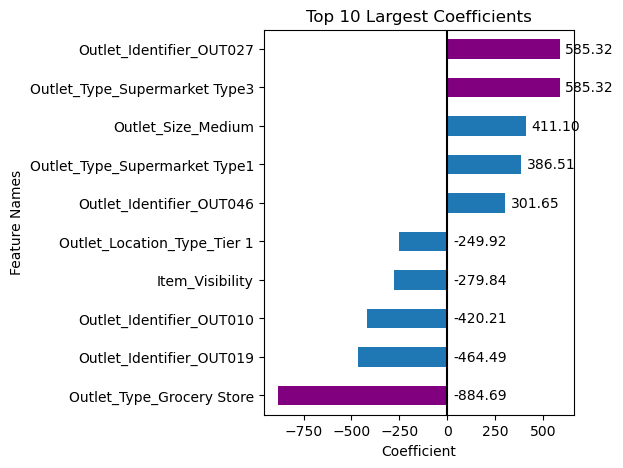

In [77]:
# Plot top 10 coeffs
ax = plot_coeffs(coeffs,top_n=10)
for bar in ax.patches:
    ## calculate center of bar
    bar_ax = bar.get_y() + bar.get_height() / 2
    ## get the value to annotate
    val = bar.get_width()
    
    if val < 0:
        val_pos = 0
    else:
        val_pos = val
    
    # ha and va stand for the horizontal and vertical alignment
    ax.annotate(f"{val:.2f}", (val_pos,bar_ax),
                ha='left', va='center',size=10,
                xytext=(4,0), textcoords='offset points')
# Highlight the top 3 most impactful features
highlight = ax.patches[9]
highlight2 = ax.patches[8]
highlight3 = ax.patches[0]
highlight.set_facecolor('purple')
highlight2.set_facecolor('purple')
highlight3.set_facecolor('purple')

### Interpreting The Model's Top 3 Most Impactful Coefficients:

- Intercept:
 - The model calculated the average prod

### Save your figure as a .png file inside your repository 

![png](Data/top_coeffs.png)